# Programming Project in Python

# Connect-4
## Training Setup for a Multilayer Perceptron Agent

by William Gatsinzi & Nico Kestel

In [1]:
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Load Data

In [2]:
data_filename = 'C4-mlp-data_RA_RA_500000.mat'
dataset = scipy.io.loadmat(data_filename)
X = dataset['data']
y = dataset['labels'][0, :]

X.shape, y.shape

((10906315, 42), (10906315,))

# Plot some samples to get a first look at our data

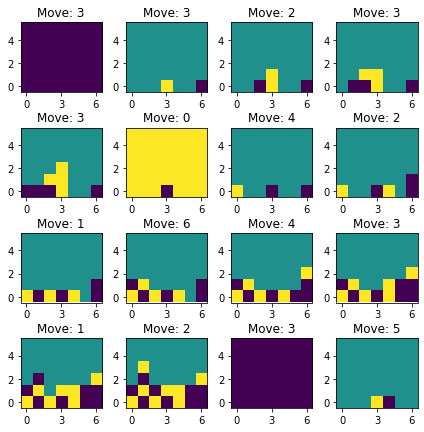

In [3]:
num_row = 4
num_col = 4
num = num_row * num_col

offset = 0

# plot boards
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,1.5*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X[offset+i].reshape(6, 7))
    ax.set_title('Move: {}'.format(y[offset+i]))
    ax.invert_yaxis()
    ax.set_xticks([0, 3, 6])
plt.tight_layout()

# A more detailed look
### Yellow: winner's discs
### Purple: opponent's discs

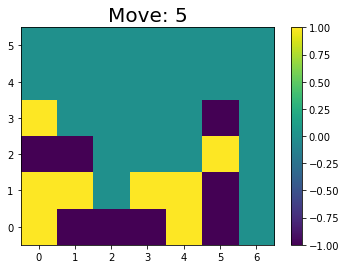

In [4]:
plt.imshow(X[35].reshape(6, 7))
plt.title('Move: {}'.format(y[35]), fontsize=20)
plt.gca().invert_yaxis()
_ = plt.colorbar()

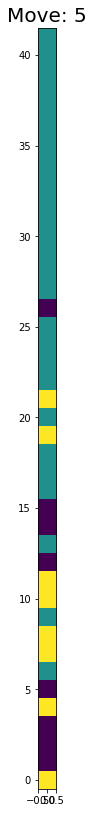

In [5]:
fig = plt.figure(figsize=(3, 14))

plt.imshow(X[35, np.newaxis].T)
plt.title('Move: {}'.format(y[35]), fontsize=20)
plt.gca().invert_yaxis()
#_ = plt.colorbar()

# How are the winner's moves distributed?
Even if our random agent has played each column with equal probability, it seems like playing columns near the center is a good idea.

[0 1 2 3 4 5 6]
[1443161 1527419 1609600 1744140 1610662 1527465 1443868]


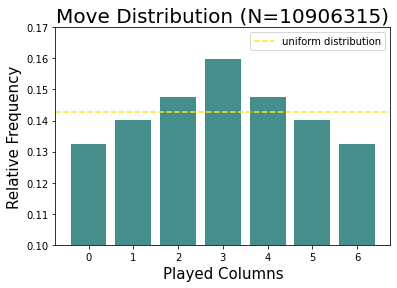

In [6]:
values, counts = np.unique(y, return_counts=True)
print(values)
print(counts)

plt.title(f'Move Distribution (N={len(y)})', fontsize=20)
plt.xlabel('Played Columns', fontsize=15)
plt.ylabel('Relative Frequency', fontsize=15)
plt.ylim((0.10, 0.17))
plt.axhline(1/7, linestyle='--', color='#FDE724', label='uniform distribution')
plt.bar(values, counts / len(y), width=.8, color='#468E8B')
_ = plt.legend()

In [7]:
n_matches = 500000
entries = len(y)
moves_per_game = entries / (2*n_matches)
moves_per_game

10.906315

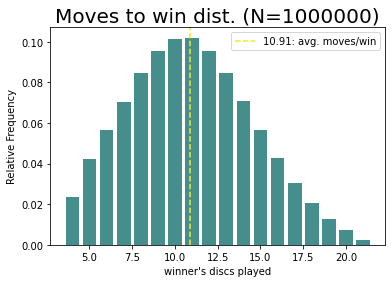

In [8]:
idx_one_to_win = np.array(np.where(abs(X).sum(axis=1) <= 1))[0, :]
X_one_to_win = X[idx_one_to_win-1]

n_moves, c_moves = np.unique(abs(X_one_to_win==1).sum(axis=1) + 1, return_counts=True)

plt.title(f'Moves to win dist. (N={X_one_to_win.shape[0]})', fontsize=20)
plt.xlabel('winner\'s discs played')
plt.ylabel(f'Relative Frequency')
plt.bar(n_moves, c_moves / X_one_to_win.shape[0], color='#468E8B')
plt.axvline(moves_per_game, color='#FDE724', linestyle='--', label=f'{moves_per_game:.2f}: avg. moves/win')
plt.legend()

In [650]:
X.shape, y.shape

((10906315, 42), (10906315,))

In [651]:
XX = X.T
XX.shape

(42, 10906315)

In [652]:
XX_mean = np.mean(XX, axis=1)
XX_mean.shape

(42,)

In [653]:
XX_center = XX - XX_mean[np.newaxis].T
XX_center.shape

(42, 10906315)

In [654]:
S = (XX_center @ XX_center.T) / XX_center.shape[1]
S.shape

(42, 42)

In [655]:
v, w = np.linalg.eig(S)

In [656]:
idx = v.argsort()[::-1] # Sort descending and get sorted indices
v = v[idx] # Use indices on eigv vector
w = w[:,idx] # 

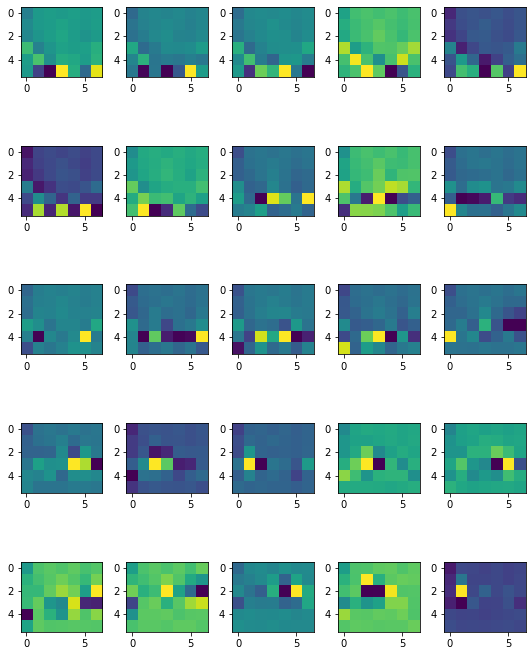

In [657]:
num_row = 5
num_col = 5
num = num_row * num_col

# plot boards
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.flipud(np.fliplr(w[i].reshape(6, 7))))
plt.tight_layout()

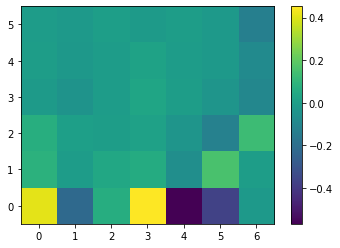

In [658]:
plt.imshow(w[0].reshape(6, 7))
plt.gca().invert_yaxis()
_ = plt.colorbar()

In [602]:
X.shape
played_discs = abs(X).sum(axis=1)
idx = played_discs.argsort()[::-1]

X_endgame = X[idx][:10000]
y_endgame = y[idx][:10000]
X_endgame.shape

(10000, 42)

In [603]:
D = X_endgame.T
D_mean = np.mean(D, axis=1)
D_center = D - D_mean[:, np.newaxis]
S_D = (D_center @ D_center.T) / D_center.shape[0]

v, w = np.linalg.eig(S_D)

idx = v.argsort()[::-1]
v = v[idx]
w = w[:, idx]
w.shape
w_nonmean = w + D_mean

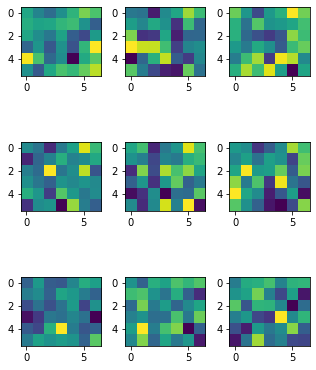

In [604]:
num_row = 3
num_col = 3
num = num_row * num_col

# plot boards
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.flipud(w[i].reshape(6, 7)))
plt.tight_layout()

In [605]:
k = 9
to_pcas = D_center.T.dot(w[:, :k])
to_pcas.shape

(10000, 9)

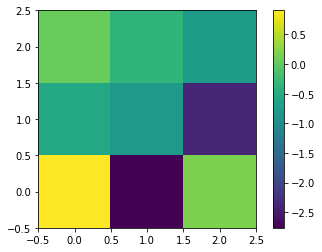

In [606]:
plt.imshow(to_pcas[30].reshape(3, 3))
plt.gca().invert_yaxis()
_ = plt.colorbar()

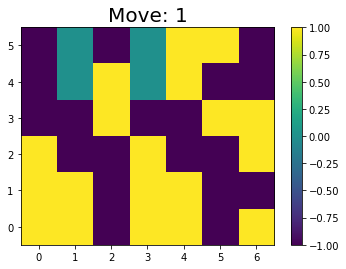

In [608]:
plt.imshow(D[:, 7000].reshape(6, 7))
plt.gca().invert_yaxis()
plt.title('Move: {}'.format(y_endgame[7000]), fontsize=20)
_ = plt.colorbar()

In [599]:
reconstructed_board = to_pcas[30][0] * w_nonmean[0]
for i in range(1, 9):
    reconstructed_board += to_pcas[30][i] * w_nonmean[i]

4

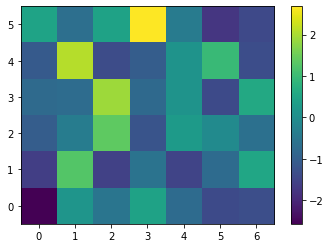

In [600]:
plt.imshow(reconstructed_board.reshape(6, 7))
plt.gca().invert_yaxis()
_ = plt.colorbar()
y_endgame[30]

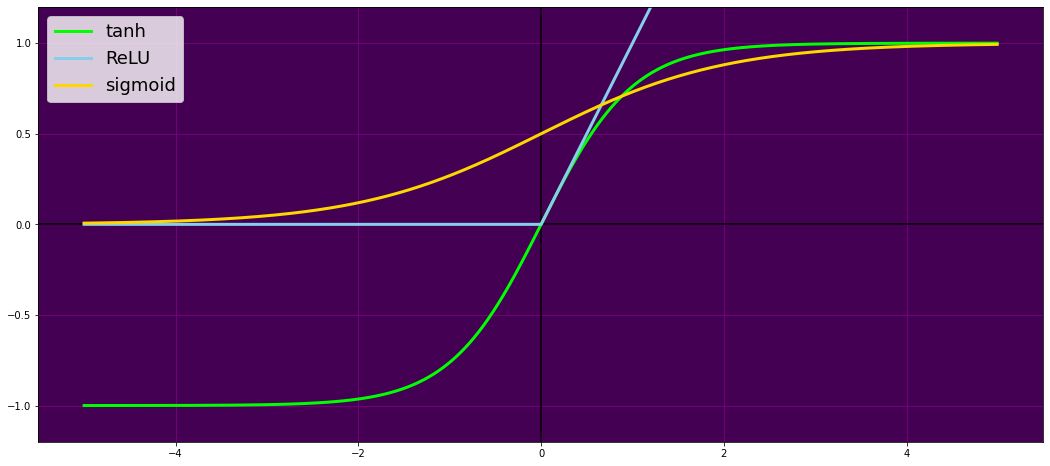

In [821]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.maximum(x, 0)


fig = plt.figure(figsize=(18, 8))
plt.axes().set_facecolor('#440154')
xrange = np.arange(-5, 5, 0.01)
plt.ylim([-1.2, 1.2])
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.plot(xrange, np.tanh(xrange), label='tanh', color='lime', linewidth=3)
plt.plot(xrange, relu(xrange), label='ReLU', color='skyblue', linewidth=3)
plt.plot(xrange, sigmoid(xrange), label='sigmoid', color='gold', linewidth=3)
plt.grid(color='purple')
plt.legend(prop={'size': 18})